In [3]:
from paths import aod_vis_xaer_concatenated, aod_vis_all_concatenated

all_aod = xarray.open_mfdataset(aod_vis_all_concatenated(), combine='nested', concat_dim="member")["AODVIS"].groupby("time.year").mean().load()
xaer_aod = xarray.open_mfdataset(aod_vis_xaer_concatenated(), combine='nested', concat_dim="member")["AODVIS"].load()
aod_ds = all_aod - xaer_aod

land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()
aod_data = aod_ds.sel(year=slice(1930, 2079)).where(land_mask > 0).mean(dim="lat").mean(dim="lon")

/tmp/ipykernel_184776/2387519297.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()


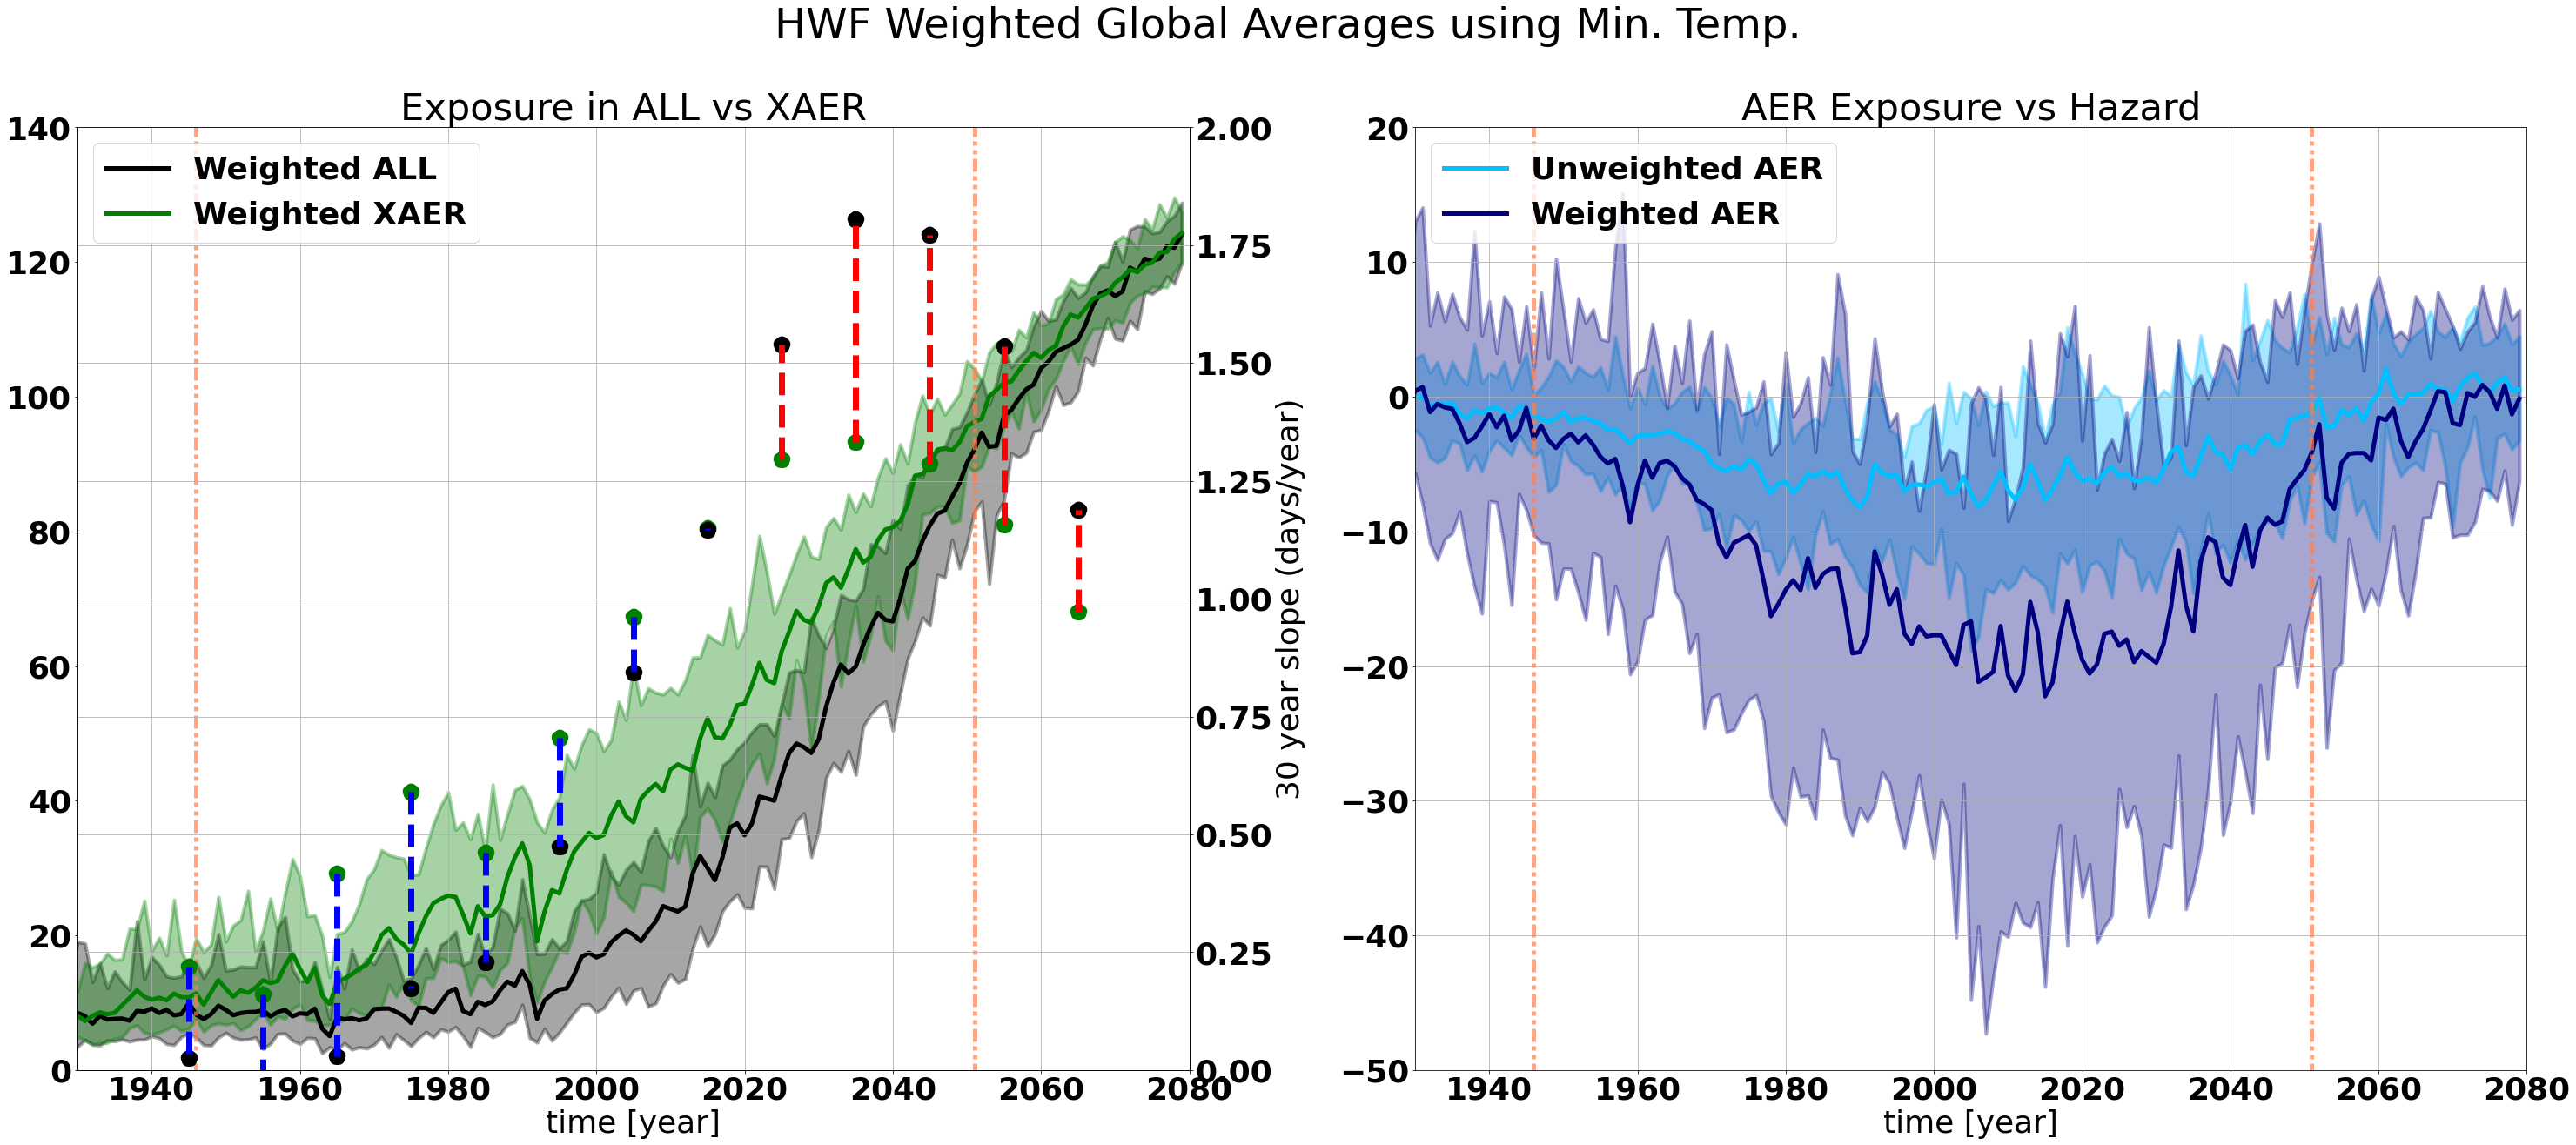

In [7]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, land_mask
from paths import population_weighted_tmin_heat_outputs as ptmin, population_2020_aggregated
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import numpy as np

ds = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()
ds = ds.where(ds>0)
world_pop = ds.sum(dim="lat").sum(dim="lon")
europe_pop = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).sum(dim="lat").sum(dim="lon")
e_na_pop = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).sum(dim="lat").sum(dim="lon")
trop_s_amer_pop = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).sum(dim="lat").sum(dim="lon")
africa_pop = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).sum(dim="lat").sum(dim="lon")
se_asia_pop = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).sum(dim="lat").sum(dim="lon")


def poly_fit(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    print(f"{txt} -> {coeff}")
    return ds.time.values*coeff[0] + coeff[1]


def poly_fit_c(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    return coeff

mean_lw = 5
mean_bls = "-"
span_a = 0.3
bls_a = 0.35
reg_pt = 14.0
all_c = "black"
xaer_c = "green"
w_c = "navy"
uw_c = "deepskyblue"
bls_lw = 4

def decadal_regressions(ds):
    # (Slope, x_init, x_final)
    #decades = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050]
    decades = [1945, 1955, 1965, 1975, 1985, 1995, 2005, 2015, 2025, 2035, 2045, 2055, 2065]
    regs = [poly_fit_c(ds.sel(time=slice(1930, 1960)))[0],
            poly_fit_c(ds.sel(time=slice(1940, 1970)))[0],
            poly_fit_c(ds.sel(time=slice(1950, 1980)))[0],
            poly_fit_c(ds.sel(time=slice(1960, 1990)))[0],
            poly_fit_c(ds.sel(time=slice(1970, 2000)))[0],
            poly_fit_c(ds.sel(time=slice(1980, 2010)))[0],
            poly_fit_c(ds.sel(time=slice(1990, 2020)))[0],
            poly_fit_c(ds.sel(time=slice(2000, 2030)))[0],
            poly_fit_c(ds.sel(time=slice(2010, 2040)))[0],
            poly_fit_c(ds.sel(time=slice(2020, 2050)))[0],
            poly_fit_c(ds.sel(time=slice(2030, 2060)))[0],
            poly_fit_c(ds.sel(time=slice(2040, 2070)))[0],
            poly_fit_c(ds.sel(time=slice(2050, 2079)))[0]]
    
    return decades, regs


def plot_regs(ax, all_regs, xaer_regs, decades, a_c=all_c, b_c=xaer_c):
    ax.scatter(decades, all_regs, color=a_c, marker="*", linewidths=reg_pt)
    ax.scatter(decades, xaer_regs, color=b_c, marker="*", linewidths=reg_pt)
    for index, year in enumerate(decades):
        if all_regs[index] < xaer_regs[index]:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="red", linewidth=reg_pt/2, linestyle="--")
        else:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="blue", linewidth=reg_pt/2, linestyle="--")

    
exp_num = "3136"
var = "HWF"

#Mask for land
landmask = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"].load()

all_min, xghg_min, xaer_min = tmin()
all_un_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(landmask>0).mean(dim="lat").mean(dim="lon").load()
xaer_un_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(landmask>0).mean(dim="lat").mean(dim="lon").load()

all_min, xghg_min, xaer_min = ptmin()
all_w_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2079)).sum(dim="lat").sum(dim="lon").load()
xaer_w_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2079)).sum(dim="lat").sum(dim="lon").load()

all_w_hwf = all_w_hwf / world_pop.sel(band=1).drop_vars("band")
xaer_w_hwf = xaer_w_hwf / world_pop.sel(band=1).drop_vars("band")

decades, all_uw_hwf_r = decadal_regressions(all_un_hwf)
decades, all_w_hwf_r = decadal_regressions(all_w_hwf)

decades, xaer_uw_hwf_r = decadal_regressions(xaer_un_hwf)
decades, xaer_w_hwf_r = decadal_regressions(xaer_w_hwf)

aer_un_hwf = all_un_hwf - xaer_un_hwf
aer_w_hwf = all_w_hwf - xaer_w_hwf

decades, aer_uw_hwf_r = decadal_regressions(aer_un_hwf)
decades, aer_w_hwf_r = decadal_regressions(aer_w_hwf)

aer_un_hwf = all_un_hwf - xaer_un_hwf
aer_w_hwf = all_w_hwf - xaer_w_hwf

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 36})
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(42, 19), facecolor='w')
f.suptitle(f"{var} Weighted Global Averages using Min. Temp.", fontsize=48)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

all_w_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=all_c, label="Weighted ALL")
ax1.fill_between(all_w_hwf.time, all_w_hwf.min(dim="member"), all_w_hwf.max(dim="member"), color=all_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
xaer_w_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=xaer_c, label="Weighted XAER")
ax1.fill_between(xaer_w_hwf.time, xaer_w_hwf.min(dim="member"), xaer_w_hwf.max(dim="member"), color=xaer_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax11 = ax1.twinx()
plot_regs(ax11, xaer_w_hwf_r, all_w_hwf_r, decades, a_c=xaer_c, b_c=all_c)
ax11.grid()
ax1.grid(axis="x")
ax1.legend(loc='upper left')
ax11.set_ylabel('30 year slope (days/year)')
ax11.set_title("Exposure in ALL vs XAER")

aer_un_hwf.mean(dim="member").plot(ax=ax2, linewidth=mean_lw, color=uw_c, label="Unweighted AER")
aer_w_hwf.mean(dim="member").plot(ax=ax2, linewidth=mean_lw, color=w_c, label="Weighted AER")
ax2.fill_between(aer_un_hwf.time, aer_un_hwf.min(dim="member"), aer_un_hwf.max(dim="member"), color=uw_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax2.fill_between(aer_w_hwf.time, aer_w_hwf.min(dim="member"), aer_w_hwf.max(dim="member"), color=w_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
#ax33 = ax3.twinx()
#plot_regs(ax22, aer_uw_hwf_r, aer_w_hwf_r, decades, a_c=uw_c, b_c=w_c)
ax2.grid()
ax2.legend(loc='upper left')
#ax33.set_ylabel('30 year slope (days/year)')
ax2.set_title("AER Exposure vs Hazard")


ax11.set_ylim(0, 2)
ax1.set_ylim(0, 140)
ax11.set_xlim(1930, 2080)

# # Plot significance boundaries
color = "coral"
alpha = 0.7

ax1.plot([1946, 1946], [-140, 140], linestyle=(0, (3, 1, 1, 1, 1, 1)), alpha=alpha, color=color, linewidth=mean_lw)
ax1.plot([2051, 2051], [-140, 140], linestyle=(0, (3, 1, 1, 1, 1, 1)), alpha=alpha, color=color, linewidth=mean_lw)

ax2.plot([1946, 1946], [-140, 140], linestyle=(0, (3, 1, 1, 1, 1, 1)), alpha=alpha, color=color, linewidth=mean_lw)
ax2.plot([2051, 2051], [-140, 140], linestyle=(0, (3, 1, 1, 1, 1, 1)), alpha=alpha, color=color, linewidth=mean_lw)

# ax33.set_ylim(-0.5, 0.5)
ax2.set_ylim(-50, 20)
ax2.set_xlim(1930, 2080)


f.tight_layout()

In [14]:
import numpy as np

np.corrcoef(aer_un_hwf.sel(time=slice(1939, 2049)).mean(dim="member"), aer_w_hwf.sel(time=slice(1939, 2049)).mean(dim="member"))

array([[1.        , 0.93474147],
       [0.93474147, 1.        ]])

In [26]:
all_min, xghg_min, xaer_min = tmin()
all_un_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(landmask>0).mean(dim="lon").mean(dim="lat").load()
xaer_un_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(landmask>0).mean(dim="lon").mean(dim="lat").load()

#ttest_ind(all_pt, xaer_pt, equal_var=False)

In [33]:
from scipy.stats import ttest_ind

un_pvals = all_un_hwf.time.values*0
for index, year in enumerate(all_un_hwf.time):
    un_pvals[index] = ttest_ind(all_un_hwf.sel(time=year).values.flatten(), xaer_un_hwf.sel(time=year).values.flatten(), equal_var=False, nan_policy="omit")[1]
(un_pvals<0.05)*all_un_hwf.time.values

array([   0.,    0.,    0.,    0.,    0.,    0., 1926.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0., 1936., 1937.,
          0., 1939.,    0.,    0., 1942., 1943.,    0.,    0., 1946.,
       1947., 1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955.,
       1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027.,
       2028., 2029., 2030., 2031., 2032., 2033., 2034., 2035., 2036.,
       2037., 2038., 2039., 2040., 2041., 2042., 2043., 2044., 2045.,
       2046., 2047.,

In [32]:
w_pvals = all_un_hwf.time.values*0
for index, year in enumerate(all_w_hwf.time):
    w_pvals[index] = ttest_ind(all_w_hwf.sel(time=year).values.flatten(), xaer_w_hwf.sel(time=year).values.flatten(), equal_var=False, nan_policy="omit")[1]
(w_pvals<0.05)*all_w_hwf.time.values

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0., 1936., 1937.,
       1938.,    0.,    0., 1941.,    0., 1943., 1944.,    0., 1946.,
       1947., 1948., 1949., 1950., 1951., 1952., 1953., 1954., 1955.,
       1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023., 2024., 2025., 2026., 2027.,
       2028., 2029., 2030., 2031., 2032., 2033., 2034., 2035., 2036.,
       2037., 2038., 2039., 2040., 2041., 2042., 2043., 2044., 2045.,
       2046., 2047.,

In [68]:
((abs(np.array(all_w_hwf_r)[6:]) - abs(np.array(all_w_hwf_r)[:7])) / abs(np.array(all_w_hwf_r)[:7])).mean()

18.183005903399877

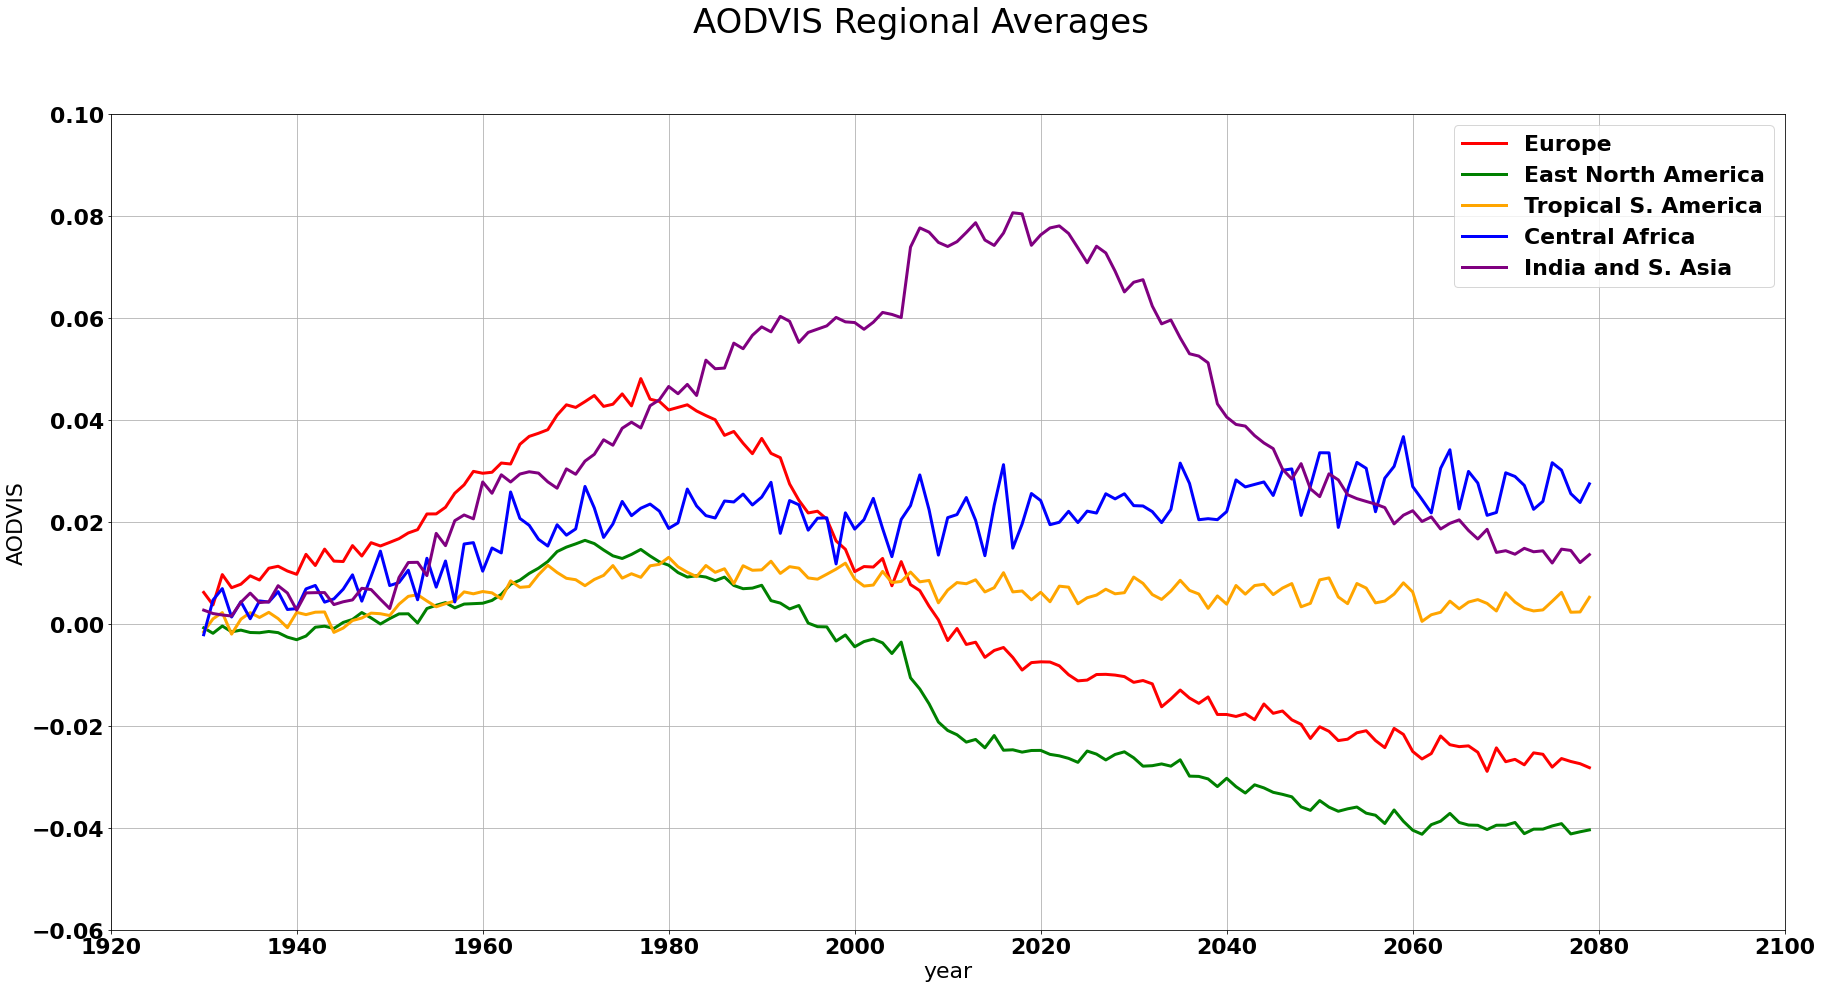

In [179]:
from paths import land_mask, aod_vis_xaer_concatenated, aod_vis_all_concatenated

all_aod = xarray.open_mfdataset(aod_vis_all_concatenated(), combine='nested', concat_dim="member")["AODVIS"].groupby("time.year").mean().load()
xaer_aod = xarray.open_mfdataset(aod_vis_xaer_concatenated(), combine='nested', concat_dim="member")["AODVIS"].load()
aod_ds = all_aod - xaer_aod

land_m = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()
aod_data = aod_ds.sel(year=slice(1930, 2079))

ds = aod_data.mean(dim="member").load()
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"].load()
land_m = land_m.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.where(land_m > 0)
europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon")
e_na = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon")
trop_s_amer = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon")
africa = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon")
se_asia = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).mean(dim="lat").mean(dim="lon")

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ax1 = plt.subplots(1, 1, figsize=(30, 15), facecolor='w')
f.suptitle(f"AODVIS Regional Averages", fontsize=34)

trops_c = "orange"
na_c = "green"
africa_c = "blue"
seasia_c = "purple"
europe_c = "red"
ls = "-"
reg_pt = "*"
lw = 3
reg_w = 10

europe.plot(ax=ax1, linestyle=ls, linewidth=lw, color=europe_c, label="Europe")
e_na.plot(ax=ax1, linestyle=ls, linewidth=lw, color=na_c, label="East North America")
trop_s_amer.plot(ax=ax1, linestyle=ls, linewidth=lw, color=trops_c, label="Tropical S. America")
africa.plot(ax=ax1, linestyle=ls, linewidth=lw, color=africa_c, label="Central Africa")
se_asia.plot(ax=ax1, linestyle=ls, linewidth=lw, color=seasia_c, label="India and S. Asia")

ax1.grid()
ax1.legend()